<a href="https://colab.research.google.com/github/Faza20-lab/Projet_stats/blob/Marine/Projet_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.stats import norm, shapiro, kstest, genextreme, genpareto
from scipy.stats import gamma
import scipy.stats as st


file_prec = '/content/drive/MyDrive/data/ERA5_prec_daily_1940_2023_FR_brittany.nc'
ds = xr.open_dataset(file_prec)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


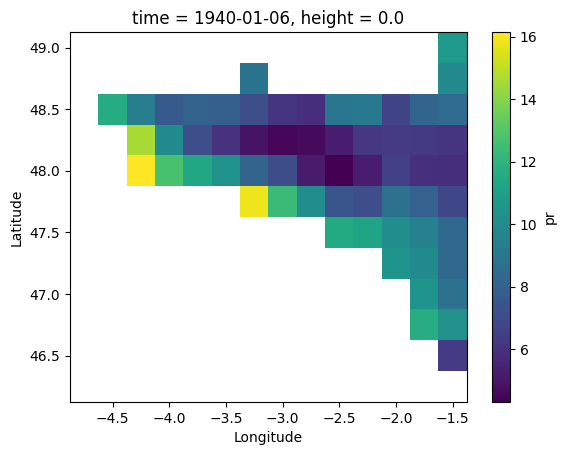

In [213]:
ds.pr[:,:,5].plot()


# **Precipitation section**

In [125]:
ds_djf = ds.sel(time=ds['time'].dt.month.isin([1, 2, 12]))
print(ds_djf)
ds_djf.sizes

<xarray.Dataset> Size: 5MB
Dimensions:    (Latitude: 12, Longitude: 14, time: 7550)
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
  * time       (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...
Data variables:
    pr         (Latitude, Longitude, time) float32 5MB ...


Frozen({'Latitude': 12, 'Longitude': 14, 'time': 7550})

In [126]:
somme_quotidienne_pr_djf=ds_djf['pr'].sum(dim=['Latitude', 'Longitude'])
print(somme_quotidienne_pr_djf)
X= somme_quotidienne_pr_djf
print(len(X))

<xarray.DataArray 'pr' (time: 7550)> Size: 30kB
array([2.7539755e-07, 0.0000000e+00, 3.9131618e-03, ..., 1.3772695e-05,
       2.4685729e-05, 2.1683841e-03], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
7550


In [127]:
!pip install netCDF4

In [128]:
ds.sizes

Frozen({'Latitude': 12, 'Longitude': 14, 'time': 30449})

In [129]:
print(ds['time'])

<xarray.DataArray 'time' (time: 30449)> Size: 244kB
array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', ..., '2023-05-11T00:00:00.000000000',
       '2023-05-12T00:00:00.000000000', '2023-05-13T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 244kB 1940-01-01 1940-01-02 ... 2023-05-13
    height   float64 8B ...


In [130]:
ds.time.values[:10]

array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', '1940-01-04T00:00:00.000000000',
       '1940-01-05T00:00:00.000000000', '1940-01-06T00:00:00.000000000',
       '1940-01-07T00:00:00.000000000', '1940-01-08T00:00:00.000000000',
       '1940-01-09T00:00:00.000000000', '1940-01-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [131]:
ds.time.values[10:]

array(['1940-01-11T00:00:00.000000000', '1940-01-12T00:00:00.000000000',
       '1940-01-13T00:00:00.000000000', ...,
       '2023-05-11T00:00:00.000000000', '2023-05-12T00:00:00.000000000',
       '2023-05-13T00:00:00.000000000'], dtype='datetime64[ns]')

In [132]:
print(ds.Latitude.values)
print(ds.Longitude.values)

[49.   48.75 48.5  48.25 48.   47.75 47.5  47.25 47.   46.75 46.5  46.25]
[-4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25 -2.
 -1.75 -1.5 ]


In [133]:
da = ds['pr'].isel(time=0)   # un jour = une carte
df = da.to_dataframe().reset_index()

In [134]:
print(df.head())

   Latitude  Longitude       time   lon   lat  height  pr
0      49.0      -4.75 1940-01-01 -4.75  49.0     0.0 NaN
1      49.0      -4.50 1940-01-01 -4.50  49.0     0.0 NaN
2      49.0      -4.25 1940-01-01 -4.25  49.0     0.0 NaN
3      49.0      -4.00 1940-01-01 -4.00  49.0     0.0 NaN
4      49.0      -3.75 1940-01-01 -3.75  49.0     0.0 NaN


In [135]:
print(da)

<xarray.DataArray 'pr' (Latitude: 12, Longitude: 14)> Size: 672B
[168 values with dtype=float32]
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
    time       datetime64[ns] 8B 1940-01-01
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...


In [136]:
print(ds['pr'].shape)

(12, 14, 30449)


In [137]:
da = ds['pr'].isel(time=0)
print(da.shape)
print(da.values.size)

(12, 14)
168


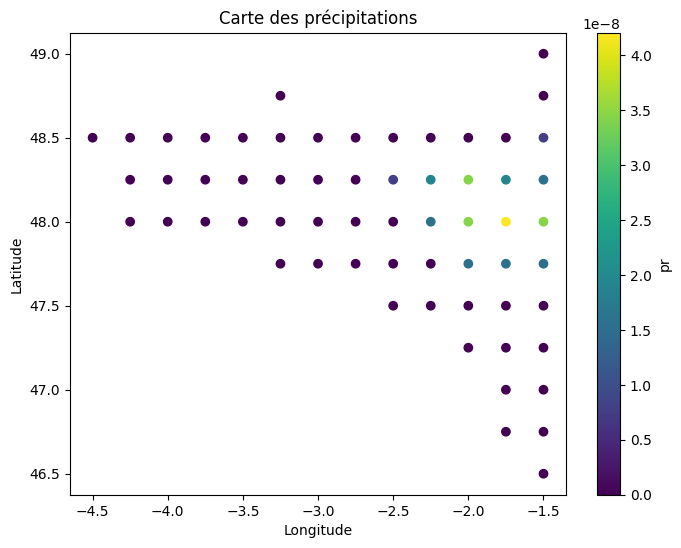

In [138]:
plt.figure(figsize=(8,6))
plt.scatter(df["Longitude"], df["Latitude"], c=df["pr"])
plt.colorbar(label="pr")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Carte des précipitations")
plt.show()

In [139]:
#conversion de kg/m²/s en mm-1
seconds_per_day = 24 * 60 * 60  # 86400

X_mm_per_day = X * seconds_per_day # x(1000/1000)

# Mettre à jour le DataArray avec une nouvelle unité
X_mm_per_day = X_mm_per_day.rename("pr_mm_per_day")
X_mm_per_day.attrs['units'] = 'mm/day'
X_mm_per_day.attrs['description'] = 'Précipitation journalière convertie de kg/m²/s → mm/j'


print(X_mm_per_day)

<xarray.DataArray 'pr_mm_per_day' (time: 7550)> Size: 30kB
array([2.3794349e-02, 0.0000000e+00, 3.3809717e+02, ..., 1.1899608e+00,
       2.1328471e+00, 1.8734839e+02], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
Attributes:
    units:        mm/day
    description:  Précipitation journalière convertie de kg/m²/s → mm/j


### **Wind section**

In [140]:
file_wind = '/content/drive/MyDrive/data/ERA5_wind_daily_1940_2023_FR_brittany.nc'
ds2 = xr.open_dataset(file_wind)

In [141]:
ds2.head()

<xarray.Dataset> Size: 708B
Dimensions:    (Latitude: 5, Longitude: 5, time: 5)
Coordinates:
  * Latitude   (Latitude) float64 40B 49.0 48.75 48.5 48.25 48.0
  * Longitude  (Longitude) float64 40B -4.75 -4.5 -4.25 -4.0 -3.75
  * time       (time) datetime64[ns] 40B 1940-01-01 1940-01-02 ... 1940-01-05
    lon        (Longitude) float64 40B ...
    lat        (Latitude) float64 40B ...
    height     float64 8B ...
Data variables:
    sfcWind    (Latitude, Longitude, time) float32 500B ...

In [142]:
ds2_djf = ds2.sel(time=ds2['time'].dt.month.isin([1, 2, 12]))
print(ds2_djf)
ds2_djf.sizes

<xarray.Dataset> Size: 5MB
Dimensions:    (Latitude: 12, Longitude: 14, time: 7550)
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
  * time       (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...
Data variables:
    sfcWind    (Latitude, Longitude, time) float32 5MB ...


Frozen({'Latitude': 12, 'Longitude': 14, 'time': 7550})

In [143]:
mean_quotidienne_sfcWind_djf=ds2_djf['sfcWind'].mean(dim=['Latitude', 'Longitude'])
print(mean_quotidienne_sfcWind_djf)
Y= mean_quotidienne_sfcWind_djf
print(len(Y))

<xarray.DataArray 'sfcWind' (time: 7550)> Size: 30kB
array([7.834759 , 7.027803 , 6.503153 , ..., 8.036703 , 7.9032125,
       7.3788795], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
7550


## **Etude des précipitations (X), distribution normale**

Paramètres normale : 0.001791202 0.0026892326
Log-vraisemblance maximale : 33971.68494381409
AIC = -67939.36988762819


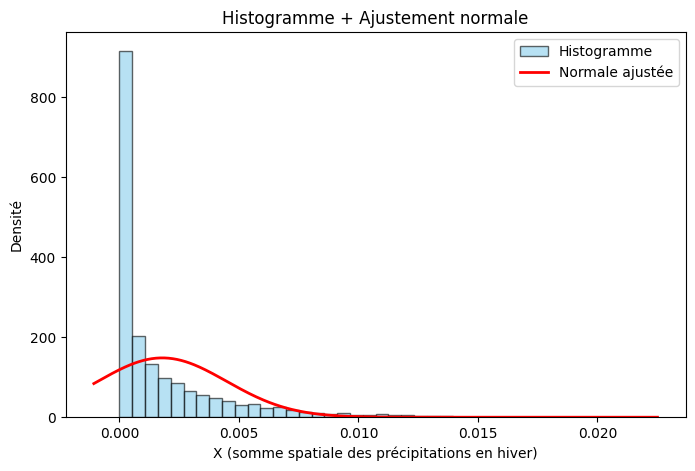

In [144]:

# Ajustement à la loi normale
mu, sigma = norm.fit(X)
print("Paramètres normale :", mu, sigma)

# Histogramme + densité normale ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(X, bins=40, density=True, alpha=0.6, color='skyblue',
         edgecolor='black', label="Histogramme")

# Courbe théorique normale ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=2, label="Normale ajustée")

plt.xlabel("X (somme spatiale des précipitations en hiver)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement normale")
plt.legend()

# Log-vraisemblance
logL = np.sum(norm.logpdf(X, mu, sigma))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 2 paramètres : mu, sigma)
AIC_norm = 2*2 - 2*logL
print("AIC =", AIC_norm)


In [145]:


# ------ Shapiro-Wilk ------
shapiro_stat, shapiro_p = shapiro(X)
print("Test Shapiro-Wilk :")
print("  statistique =", shapiro_stat)
print("  p-value     =", shapiro_p, "\n")

# ------ KS (Kolmogorov-Smirnov) ------
ks_stat, ks_p = kstest(X, 'norm', args=(mu, sigma))
print("Test KS (paramètres estimés) :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)



Test Shapiro-Wilk :
  statistique = 0.6938399482096498
  p-value     = 2.6007504597831528e-79 

Test KS (paramètres estimés) :
  statistique = 0.25268329868908956
  p-value     = 0.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7550.
  res = hypotest_fun_out(*samples, **kwds)


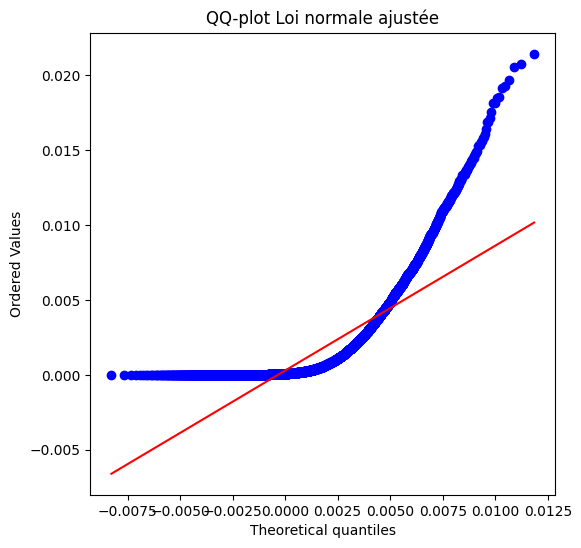

In [146]:
# Diagramme Quantile-Quantile de la normale
plt.figure(figsize=(6,6))
st.probplot(X, dist=norm, sparams=(mu, sigma), plot=plt)
plt.title("QQ-plot Loi normale ajustée")
plt.show()

# **GEV précipitations:**

On définit un deux variables WinterPI qui correspond à la somme des précipitations d'un hiver (DJF) en mm et max_par_hiver qui correspond au précipitation par hiver sur un mois en mm

In [147]:

# --- Conversion de pr de kg/m²/s en mm/jour ---
ds['pr'] = ds['pr'] * 86400  # 86400 secondes par jour
ds['season'] = ds['time'].dt.season

# Sélectionner seulement les jours d'hiver
ds_djf = ds.sel(time=ds['season'] == 'DJF')

# --- Somme quotidienne spatiale (Latitude + Longitude) ---
somme_quotidienne_pr_djf = ds_djf['pr'].sum(dim=['Latitude', 'Longitude']) #array

# --- Somme mensuelle spatiale ---
somme_mois_pr_djf = ds_djf['pr'].groupby('time.month').sum(dim=['Latitude', 'Longitude']) #array

# --- Somme totale par hiver (chaque année) ---
# Note : On utilise groupby 'time.year'. Décembre appartient à l'année suivante pour l'hiver DJF
# Pour cela, on décale le mois de décembre d'une année
annee_hiver = ds_djf['time.year'].where(ds_djf['time.month'] != 12, ds_djf['time.year'] + 1)
somme_hiver = ds_djf['pr'].groupby(annee_hiver).sum(dim=['time', 'Latitude', 'Longitude'])
print("année hiver", annee_hiver)


# --- Créer un DataArray WinterPI  et Somme par mois---
Somme_mois = somme_mois_pr_djf.rename("Somme mois")

# Bloc maxima par saison
# Assigner la coordonnée hiver à Somme_mois
# Max de précipitations par mois dans chaque hiver


#max_par_hiver = (ds_djf['pr'].groupby('time.month').sum(dim=['Latitude', 'Longitude'])).max



# Somme sur tout l'hiver
WinterPI = somme_hiver.rename("WinterPI")
WinterPI = WinterPI.assign_coords(year=np.unique(annee_hiver.values))

# --- Afficher le résultat ---
print(WinterPI)
print(len(WinterPI))


année hiver <xarray.DataArray 'year' (time: 7550)> Size: 60kB
array([1940, 1940, 1940, ..., 2023, 2023, 2023])
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B 0.0
<xarray.DataArray 'WinterPI' (year: 84)> Size: 336B
array([ 8377.799 , 15172.459 ,  7901.8545, 16133.89  ,  6146.8125,
       11490.911 , 13386.957 , 11288.445 , 13297.986 , 12569.238 ,
       13358.568 , 17136.406 ,  9778.834 ,  9171.723 ,  8722.051 ,
       15582.819 , 11727.835 , 17879.463 , 15123.016 , 11449.756 ,
       18136.957 , 16163.619 , 14360.942 ,  8398.139 ,  6663.288 ,
       12529.6875, 20239.215 , 14259.468 , 11374.627 , 12065.504 ,
       15991.568 ,  9821.185 , 15085.014 ,  9259.478 , 17334.346 ,
        9132.387 ,  5769.491 , 17019.125 , 19609.29  , 24382.764 ,
       16323.769 ,  9715.227 , 18556.426 , 13831.113 , 15407.055 ,
       14046.289 , 16734.344 ,  9234.358 , 20176.715 ,  7646.9746,
       24017.86  , 12432.268 ,  3969.125 , 11236.

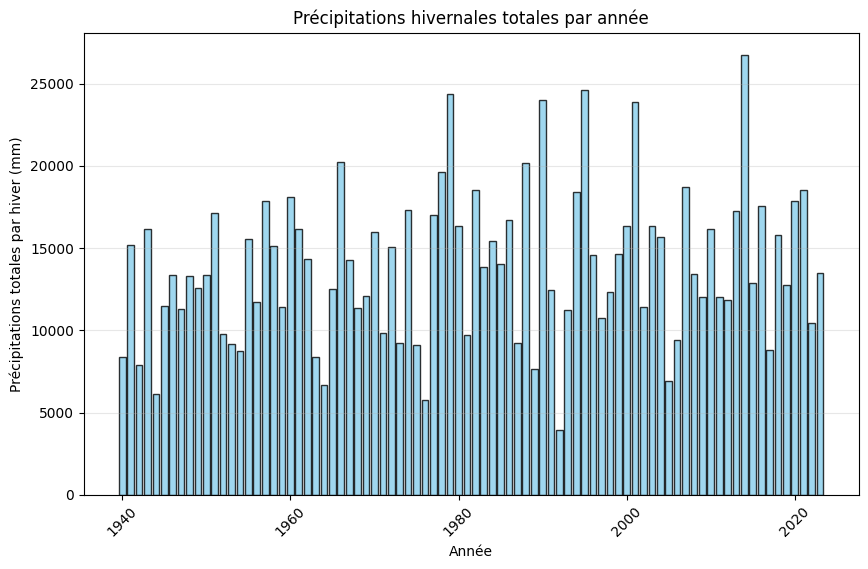

In [148]:
# Histogramme des précipitations par hiver pour chaque année
plt.figure(figsize=(10,6))
plt.bar(WinterPI.year, WinterPI.values, color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel("Année")
plt.ylabel("Précipitations totales par hiver (mm)")
plt.title("Précipitations hivernales totales par année")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

# GEV sur WinterPI

On étudie d'abord la gev sur WPI

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3562077006.py:16: SyntaxWarning: invalid escape sequence '\m'
  label=f'Normale ajustée\n($\mu$={mu:.0f}, $\sigma$={sigma:.0f})')
/tmp/ipython-input-3562077006.py:16: SyntaxWarning: invalid escape sequence '\s'
  label=f'Normale ajustée\n($\mu$={mu:.0f}, $\sigma$={sigma:.0f})')


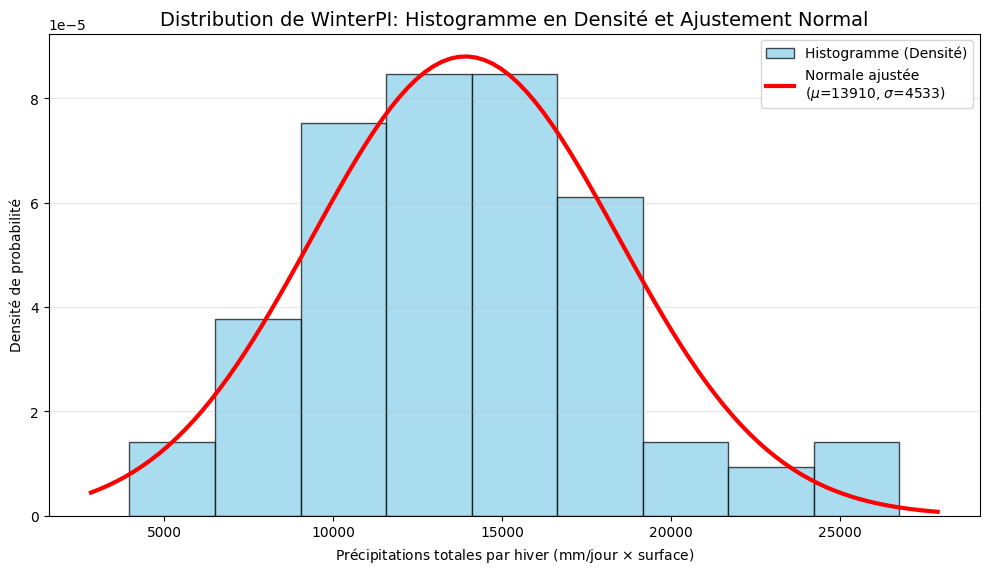

In [149]:
# --- Tracé de l'histogramme en densité ---
plt.figure(figsize=(10,6))
# Calculer le nombre de bins (souvent sqrt(N) ou formule de Freedman-Diaconis)
bins = int(np.sqrt(len(WinterPI.values)))

plt.hist(WinterPI.values, bins=bins, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Histogramme (Densité)')

# --- Courbe normale ajustée ---
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 100)
# Utilisez les vraies valeurs mu et sigma obtenues
mu, sigma = norm.fit(WinterPI.values)
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=3,
         label=f'Normale ajustée\n($\mu$={mu:.0f}, $\sigma$={sigma:.0f})')

# --- Labels et légende ---
plt.xlabel("Précipitations totales par hiver (mm/jour $\\times$ surface)")
plt.ylabel("Densité de probabilité")
plt.title("Distribution de WinterPI: Histogramme en Densité et Ajustement Normal", fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Paramètres GEV ajustés :
 c (shape) = -7.396, loc = 3969.84, scale = 5.32


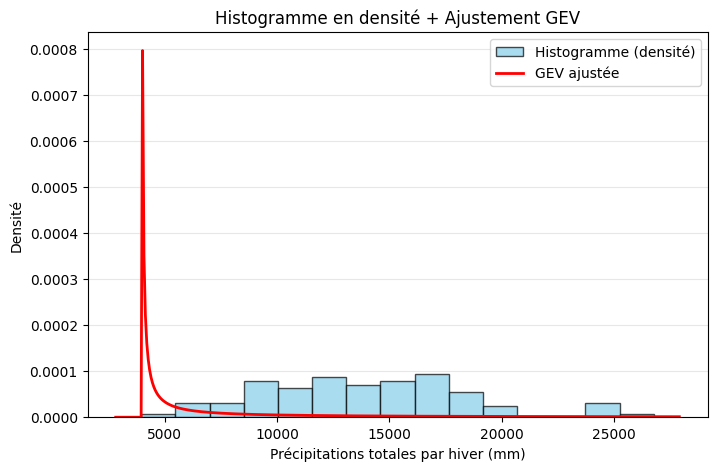

In [150]:

# --- Ajustement GEV ---
# genextreme utilise un paramètre c (shape), loc (location), scale (scale)
c, loc, scale = genextreme.fit(WinterPI.values)
print(f"Paramètres GEV ajustés :\n c (shape) = {c:.3f}, loc = {loc:.2f}, scale = {scale:.2f}")

# --- Histogramme en densité ---
plt.figure(figsize=(8,5))
plt.hist(WinterPI.values, bins=15, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogramme (densité)')

# --- Courbe GEV ajustée ---
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genextreme.pdf(xx, c, loc=loc, scale=scale), 'r-', lw=2, label='GEV ajustée')

# --- Labels et légende ---
plt.xlabel("Précipitations totales par hiver (mm)")
plt.ylabel("Densité")
plt.title("Histogramme en densité + Ajustement GEV")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()



In [151]:

# Construction de la CDF paramétrée
gev_cdf = lambda x: genextreme(c, loc=loc, scale=scale).cdf(x)

# KS-test
ks_stat, ks_p = kstest(WinterPI.values, gev_cdf)

print("Test KS (GEV ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genextreme.logpdf(WinterPI.values, c, loc=loc, scale=scale))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 2 paramètres)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)



Test KS (GEV ajustée) :
  Statistique = 0.6948282536842939
  p-value     = 4.667345283432698e-41
Log-vraisemblance maximale : -1043.0548688937322
AIC = 2092.1097377874644


**Raisons du Mauvais Ajustement**

La cause principale de l'échec est due à la dégénérescence numérique causée par l'inadéquation de la GEV pour les données.

**GEV Inappropriée pour les Sommes :** La variable WinterPI est une somme accumulée (non des maximums). La GEV est théoriquement réservée à la série des maximums annuels (AMS).

**Instabilité Numérique :** L'ajustement échoue et la valeur de σ=5.3 est la preuve de la dégénérescence. L'algorithme a convergé vers une solution où la GEV est presque une fonction Dirac, d'où la courbe rouge très étroite et haute qui n'a pas de sens physique par rapport à la dispersion de l'histogramme.

# GEV sur max par saison

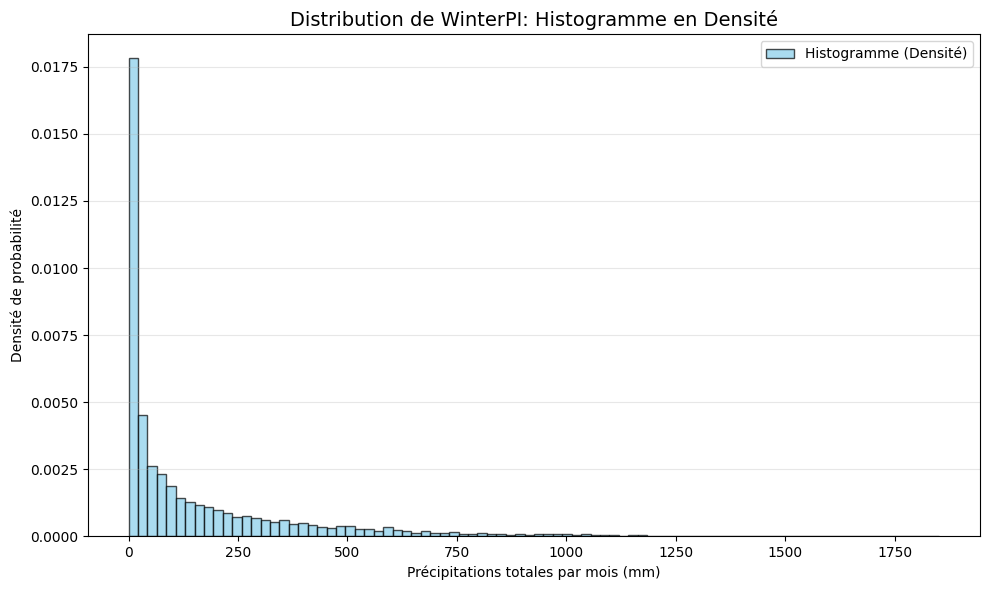

In [152]:
# --- Tracé de l'histogramme en densité ---
plt.figure(figsize=(10,6))
# Calculer le nombre de bins (souvent sqrt(N) ou formule de Freedman-Diaconis)
bins = int(np.sqrt(len(Somme_mois)))

plt.hist(Somme_mois, bins=bins, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Histogramme (Densité)')

# --- Labels et légende ---
plt.xlabel("Précipitations totales par mois (mm)")
plt.ylabel("Densité de probabilité")
plt.title("Distribution de WinterPI: Histogramme en Densité", fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Extraire les valeurs numériques
data_max_values = data_max.values

# Ajustement GEV
c, loc, scale = genextreme.fit(data_max_values)

# Histogramme des maxima
plt.figure(figsize=(10,6))
bins = int(np.sqrt(len(data_max_values)))
plt.hist(data_max_values, bins=bins, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogramme (Maxima)')

# Courbe GEV ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genextreme.pdf(xx, c, loc=loc, scale=scale), 'r-', lw=2, label='GEV ajustée')

plt.xlabel("Précipitations maximales DJF (mm)")
plt.ylabel("Densité de probabilité")
plt.title("Histogramme des maxima DJF + Ajustement GEV")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Paramètres GEV
print(f"Paramètres GEV : shape(c)={c:.3f}, loc={loc:.1f}, scale={scale:.1f}")




In [ ]:
# Construction de la CDF paramétrée
gev_cdf = lambda x: genextreme(c, loc=loc, scale=scale).cdf(x)

# KS-test
ks_stat, ks_p = kstest(data_max, gev_cdf)

print("Test KS (GEV ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# **GPD précipitations**


# GPD sur WinterPI

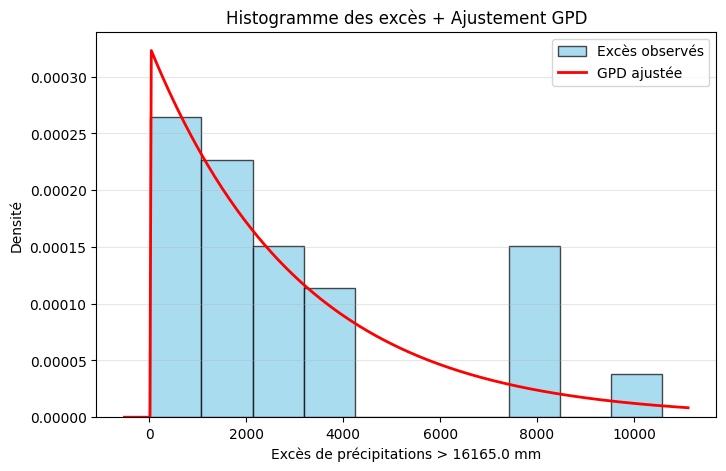

Paramètres GPD : shape(c)=-0.015, loc=12.4, scale=3070.9


In [166]:

# --- 1. Choisir un seuil pour les extrêmes ---
seuil = np.percentile(WinterPI.values, 70)  # 70ème percentile
exceedances = WinterPI.values[WinterPI.values > seuil] - seuil  # excès au-dessus du seuil

# --- 2. Ajuster la GPD aux excès ---
c, loc, scale = genpareto.fit(exceedances)

# --- 3. Histogramme des excès (densité) ---
plt.figure(figsize=(8,5))
plt.hist(exceedances, bins=10, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Excès observés')

# --- 4. Courbe GPD ajustée ---
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genpareto.pdf(xx, c, loc=loc, scale=scale), 'r-', lw=2, label='GPD ajustée')

# --- 5. Labels et légende ---
plt.xlabel(f"Excès de précipitations > {seuil:.1f} mm")
plt.ylabel("Densité")
plt.title("Histogramme des excès + Ajustement GPD")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- 6. Affichage des paramètres ---
print(f"Paramètres GPD : shape(c)={c:.3f}, loc={loc:.1f}, scale={scale:.1f}")


In [168]:
# Construction de la  paramétrée
gpd_cdf = lambda x: genpareto(c, loc=loc, scale=scale).cdf(x)

# KS-test
ks_stat, ks_p = kstest(exceedances, gpd_cdf)

print("Test KS (GPD ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genpareto.logpdf(exceedances, c, loc=loc, scale=scale))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 3)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)

Test KS (GPD ajustée) :
  Statistique = 0.12264401154475968
  p-value     = 0.8030411135576355
Log-vraisemblance maximale : -225.36163823556
AIC = 456.72327647112


# GPD sur Cumul mensuel MPI

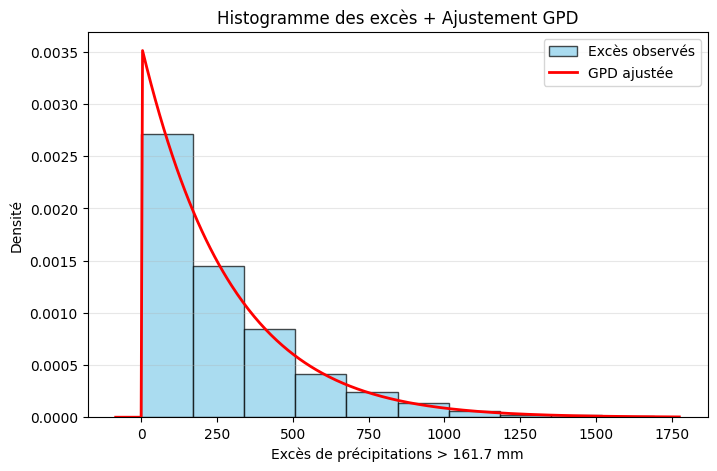

Paramètres GPD : shape(c)=-0.045, loc=0.1, scale=280.8


In [169]:
# --- 1. Choisir un seuil pour les extrêmes ---
seuil = np.percentile(Somme_mois, 70)  # 70ème percentile
exceedances = Somme_mois[Somme_mois > seuil] - seuil  # excès au-dessus du seuil

# --- 2. Ajuster la GPD aux excès ---
c, loc, scale = genpareto.fit(exceedances)

# --- 3. Histogramme des excès (densité) ---
plt.figure(figsize=(8,5))
plt.hist(exceedances, bins=10, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Excès observés')

# --- 4. Courbe GPD ajustée ---
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genpareto.pdf(xx, c, loc=loc, scale=scale), 'r-', lw=2, label='GPD ajustée')

# --- 5. Labels et légende ---
plt.xlabel(f"Excès de précipitations > {seuil:.1f} mm")
plt.ylabel("Densité")
plt.title("Histogramme des excès + Ajustement GPD")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- 6. Affichage des paramètres ---
print(f"Paramètres GPD : shape(c)={c:.3f}, loc={loc:.1f}, scale={scale:.1f}")

In [170]:
# Construction de la  paramétrée
gpd_cdf = lambda x: genpareto(c, loc=loc, scale=scale).cdf(x)

# KS-test
ks_stat, ks_p = kstest(exceedances, gpd_cdf)

print("Test KS (GPD ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genpareto.logpdf(exceedances, c, loc=0, scale=scale))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 3)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)

Test KS (GPD ajustée) :
  Statistique = 0.015636077888671218
  p-value     = 0.6311714352858877
Log-vraisemblance maximale : -14933.915863363876
AIC = 29873.831726727753


## **Etude des vents, distribution normale**

Paramètres normale : 6.404704 2.435008
Log-vraisemblance maximale : -17432.10893783786
AIC = 34868.21787567572
Test Shapiro-Wilk :
  statistique = 0.9672969474116843
  p-value     = 2.9708823471227656e-38 

Test KS :
  statistique = 0.05665483683174516
  p-value     = 1.6634431693019088e-21


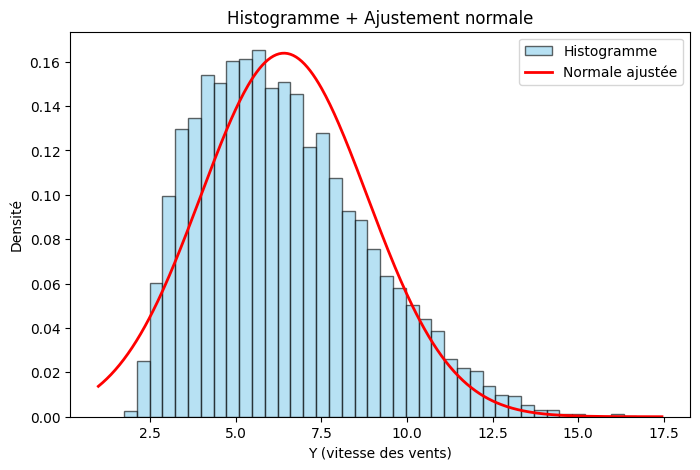

In [191]:
# Pour Y
# Ajustement à la loi normale
mu, sigma = norm.fit(Y)
print("Paramètres normale :", mu, sigma)

# Histogramme + densité normale ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(Y, bins=40, density=True, alpha=0.6, color='skyblue',
         edgecolor='black', label="Histogramme")

# Courbe théorique normale ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=2, label="Normale ajustée")

plt.xlabel("Y (vitesse des vents)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement normale")
plt.legend()

# Log-vraisemblance
logL = np.sum(norm.logpdf(Y, mu, sigma))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 2 paramètres : mu, sigma)
AIC_norm = 2*2 - 2*logL
print("AIC =", AIC_norm)

# ------ Shapiro-Wilk ------
shapiro_stat, shapiro_p = shapiro(Y)
print("Test Shapiro-Wilk :")
print("  statistique =", shapiro_stat)
print("  p-value     =", shapiro_p, "\n")

# ------ KS (Kolmogorov-Smirnov) ------
ks_stat, ks_p = kstest(Y, 'norm', args=(mu, sigma))
print("Test KS :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)


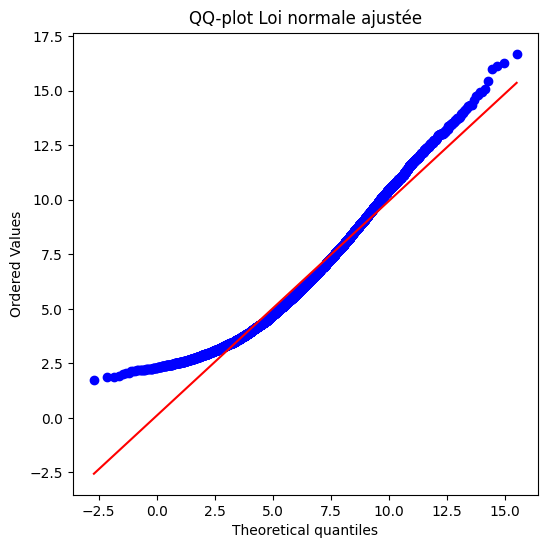

In [172]:
# Diagramme Quantile-Quantile de la noramle
plt.figure(figsize=(6,6))
st.probplot(Y, dist=norm, sparams=(mu, sigma), plot=plt)
plt.title("QQ-plot Loi normale ajustée")
plt.show()

##  GEV max mensuel

In [189]:
# --- Grouper par année et par mois ---
Y_max = Y.groupby('time.year').map(lambda x: x.groupby('time.month').max(dim='time'))

# --- Transformer en numpy array (shape = nb_annees × 3) ---
Y_max_values = np.array([x.values for x in Y_max])
print("Shape avant flatten :", Y_max_values.shape)

# --- Transformer en vecteur 1D (flatten) ---
Y_max_month = Y_max_values.flatten()
print("Shape après flatten :", Y_max_month.shape)

# --- Affichage des 20 premières valeurs ---
print(Y_max_month)


Shape avant flatten : (84, 3)
Shape après flatten : (252,)
[ 7.83475924 10.09994888 11.20478725 11.36468506 13.50259304 11.81658554
 12.40323639  8.05217838  9.75095272 14.13482094 10.60960197 11.50073433
 10.40312195  9.17426205 11.91625214 11.89690399 11.68322182 11.62458134
 12.69151115 12.2922039  11.75441933  8.58282948  7.65015554 11.08776093
 11.05125523  9.63924217 11.00717354 13.68508244 12.07698154  9.6964407
  7.81553268 12.58374977 10.1496439  11.85835075 14.19670296 13.02905083
 12.18385792  9.53630257 11.44875813 10.08596706 12.15663147  7.80696297
 10.04051399 10.71097374 11.79619503 12.22029305 11.93211174 12.85323143
  9.89169121  9.5182848  10.98441696  9.88213634 11.21700287 10.84153748
 11.98259163 11.102705   10.94130898 12.62800789  8.33229256 12.30474758
 11.94174862  9.79757881 11.62707424 11.61027718 11.22255135 11.81040192
 13.01650906 11.28274155 10.92477703 10.21255302  9.2666626   8.81964588
  7.04698038  8.37511063 10.15585995 11.72894764  7.79507208 13.43

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2695525998.py:16: SyntaxWarning: invalid escape sequence '\m'
  label=f'Normale ajustée\n($\mu$={mu:.0f}, $\sigma$={sigma:.0f})')
/tmp/ipython-input-2695525998.py:16: SyntaxWarning: invalid escape sequence '\s'
  label=f'Normale ajustée\n($\mu$={mu:.0f}, $\sigma$={sigma:.0f})')


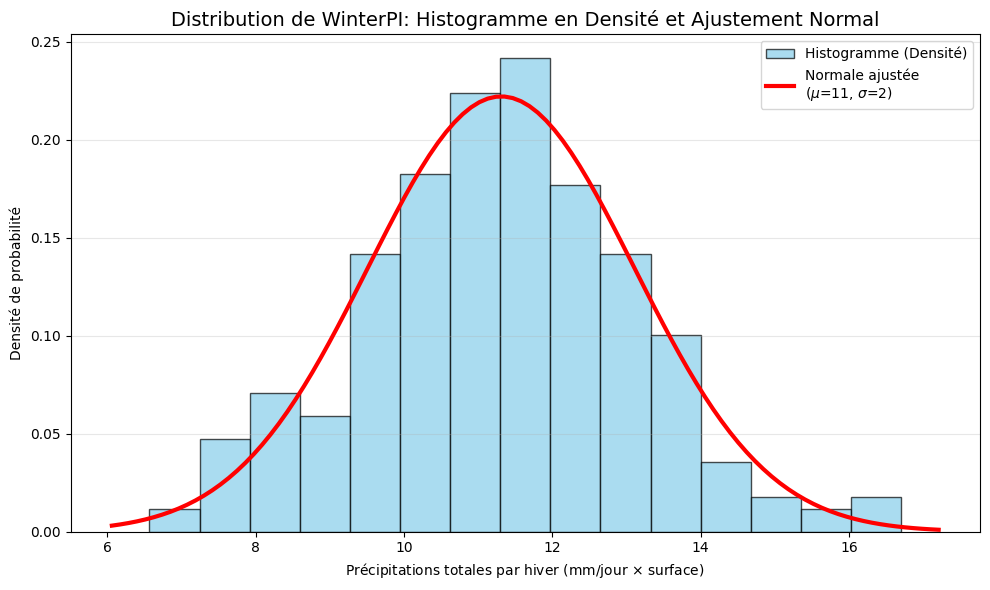

In [202]:
# --- Tracé de l'histogramme en densité ---
plt.figure(figsize=(10,6))
# Calculer le nombre de bins (souvent sqrt(N) ou formule de Freedman-Diaconis)
bins = int(np.sqrt(len(Y_max_month[:-1])))

plt.hist(Y_max_month[:-1], bins=bins, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Histogramme (Densité)')

# --- Courbe normale ajustée ---
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 100)
# Utilisez les vraies valeurs mu et sigma obtenues
mu, sigma = norm.fit(Y_max_month[:-1])
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=3,
         label=f'Normale ajustée\n($\mu$={mu:.0f}, $\sigma$={sigma:.0f})')

# --- Labels et légende ---
plt.xlabel("Précipitations totales par hiver (mm/jour $\\times$ surface)")
plt.ylabel("Densité de probabilité")
plt.title("Distribution de WinterPI: Histogramme en Densité et Ajustement Normal", fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [205]:

# ------ Shapiro-Wilk ------
shapiro_stat, shapiro_p = shapiro(Y_max_month[:-1])
print("Test Shapiro-Wilk :")
print("  statistique =", shapiro_stat)
print("  p-value     =", shapiro_p, "\n")

# ------ KS (Kolmogorov-Smirnov) ------
ks_stat, ks_p = kstest(Y_max_month[:-1], 'norm', args=(mu, sigma))
print("Test KS (paramètres estimés) :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)


Test Shapiro-Wilk :
  statistique = 0.9950057326008281
  p-value     = 0.5878902888353069 

Test KS (paramètres estimés) :
  statistique = 0.028550054059836683
  p-value     = 0.983136668978971


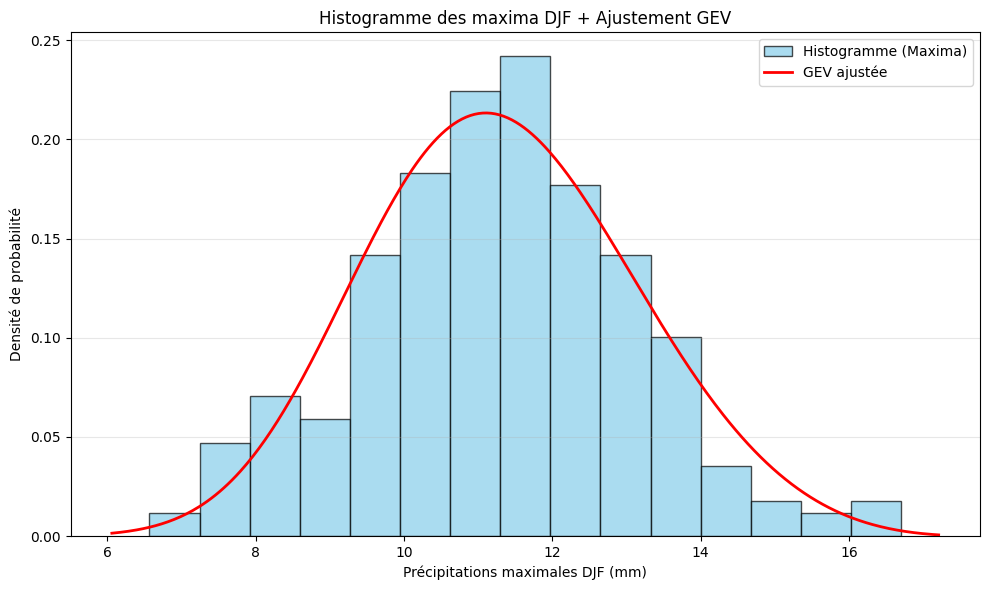

Paramètres GEV : shape(c)=0.237, loc=10.6, scale=1.8


In [209]:


# Ajustement GEV
c, loc, scale = genextreme.fit(Y_max_month[:-1])

# Histogramme des maxima
plt.figure(figsize=(10,6))
bins = int(np.sqrt(len(Y_max_month[:-1])))
plt.hist(Y_max_month[:-1], bins=bins, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogramme (Maxima)')

# Courbe GEV ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genextreme.pdf(xx, c, loc=loc, scale=scale), 'r-', lw=2, label='GEV ajustée')

plt.xlabel("Précipitations maximales DJF (mm)")
plt.ylabel("Densité de probabilité")
plt.title("Histogramme des maxima DJF + Ajustement GEV")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Paramètres GEV
print(f"Paramètres GEV : shape(c)={c:.3f}, loc={loc:.1f}, scale={scale:.1f}")


In [210]:
# Construction de la CDF paramétrée
gev_cdf = lambda x: genextreme(c, loc=loc, scale=scale).cdf(x)

# KS-test
ks_stat, ks_p = kstest(Y_max_month[:-1], gev_cdf)

print("Test KS (GEV ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

Test KS (GEV ajustée) :
  Statistique = 0.03537979188333873
  p-value     = 0.9006611739045735
